# Importing Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torchvision.transforms as transforms
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.transforms.functional import to_tensor  


# Define dataset path

In [2]:
DATASET_DIR = 'Data'  
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
TRAIN_CSV = os.path.join(DATASET_DIR, 'Training_set.csv')
TEST_CSV = os.path.join(DATASET_DIR, 'Testing_set.csv')


# Load CSV files

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Inspect basic info

In [4]:
print("🔎 Training Data Sample:")
print(train_df.head())
print("\n🧼 Missing Values:")
print(train_df.isnull().sum())

🔎 Training Data Sample:
      filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

🧼 Missing Values:
filename    0
label       0
dtype: int64


# Analyze class distribution

In [5]:
print("\n📊 Class Distribution:")
class_counts = train_df['label'].value_counts()
print(class_counts)


📊 Class Distribution:
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64


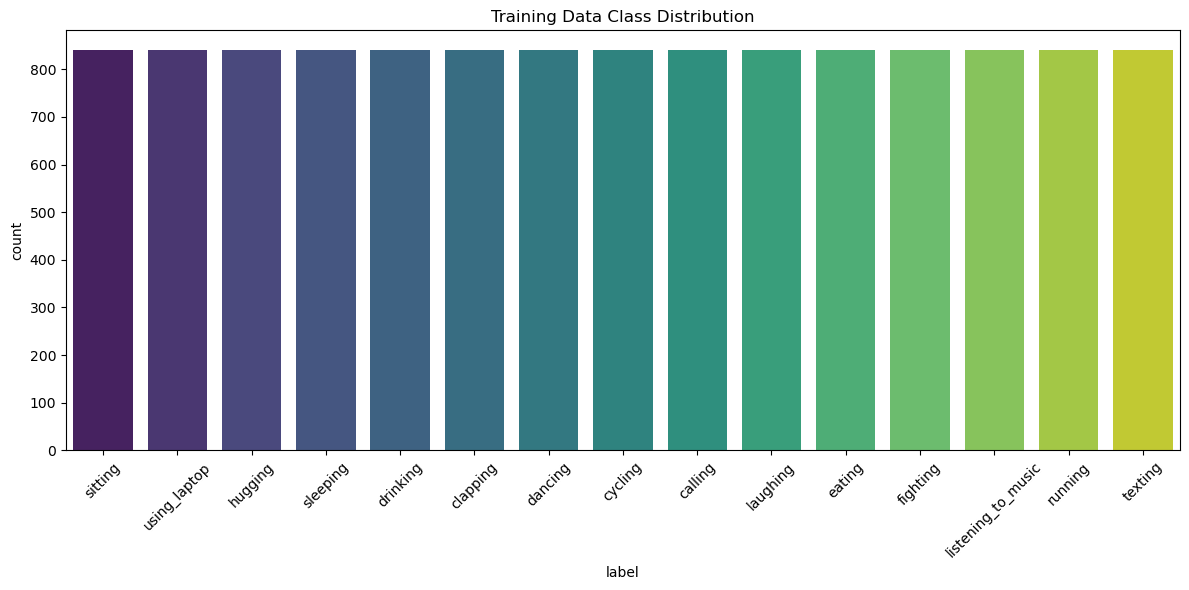

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(data=train_df, x='label', order=class_counts.index, palette='viridis')
plt.xticks(rotation=45)
plt.title("Training Data Class Distribution")
plt.tight_layout()
plt.show()


# Image property check

In [7]:
sample_image_path = os.path.join(TRAIN_DIR, train_df.iloc[0]['filename'])
img = Image.open(sample_image_path)
print(f"🖼️ Sample Image Size: {img.size}, Mode: {img.mode}")
img.show()

🖼️ Sample Image Size: (240, 160), Mode: RGB


# Display sample images per class

In [8]:
def show_samples(df, data_dir, n=5):
    unique_labels = df['label'].unique()
    fig, axes = plt.subplots(len(unique_labels), n, figsize=(n*3, len(unique_labels)*3))
    
    for i, label in enumerate(unique_labels):
        sample_imgs = df[df['label'] == label].sample(n=n, random_state=42)
        for j, img_name in enumerate(sample_imgs['filename']):
            img_path = os.path.join(data_dir, img_name)
            image = Image.open(img_path)
            axes[i][j].imshow(image)
            axes[i][j].axis('off')
            if j == 0:
                axes[i][j].set_ylabel(label, rotation=0, size='large')
    plt.tight_layout()
    plt.show()

📷 Sample images from each class:


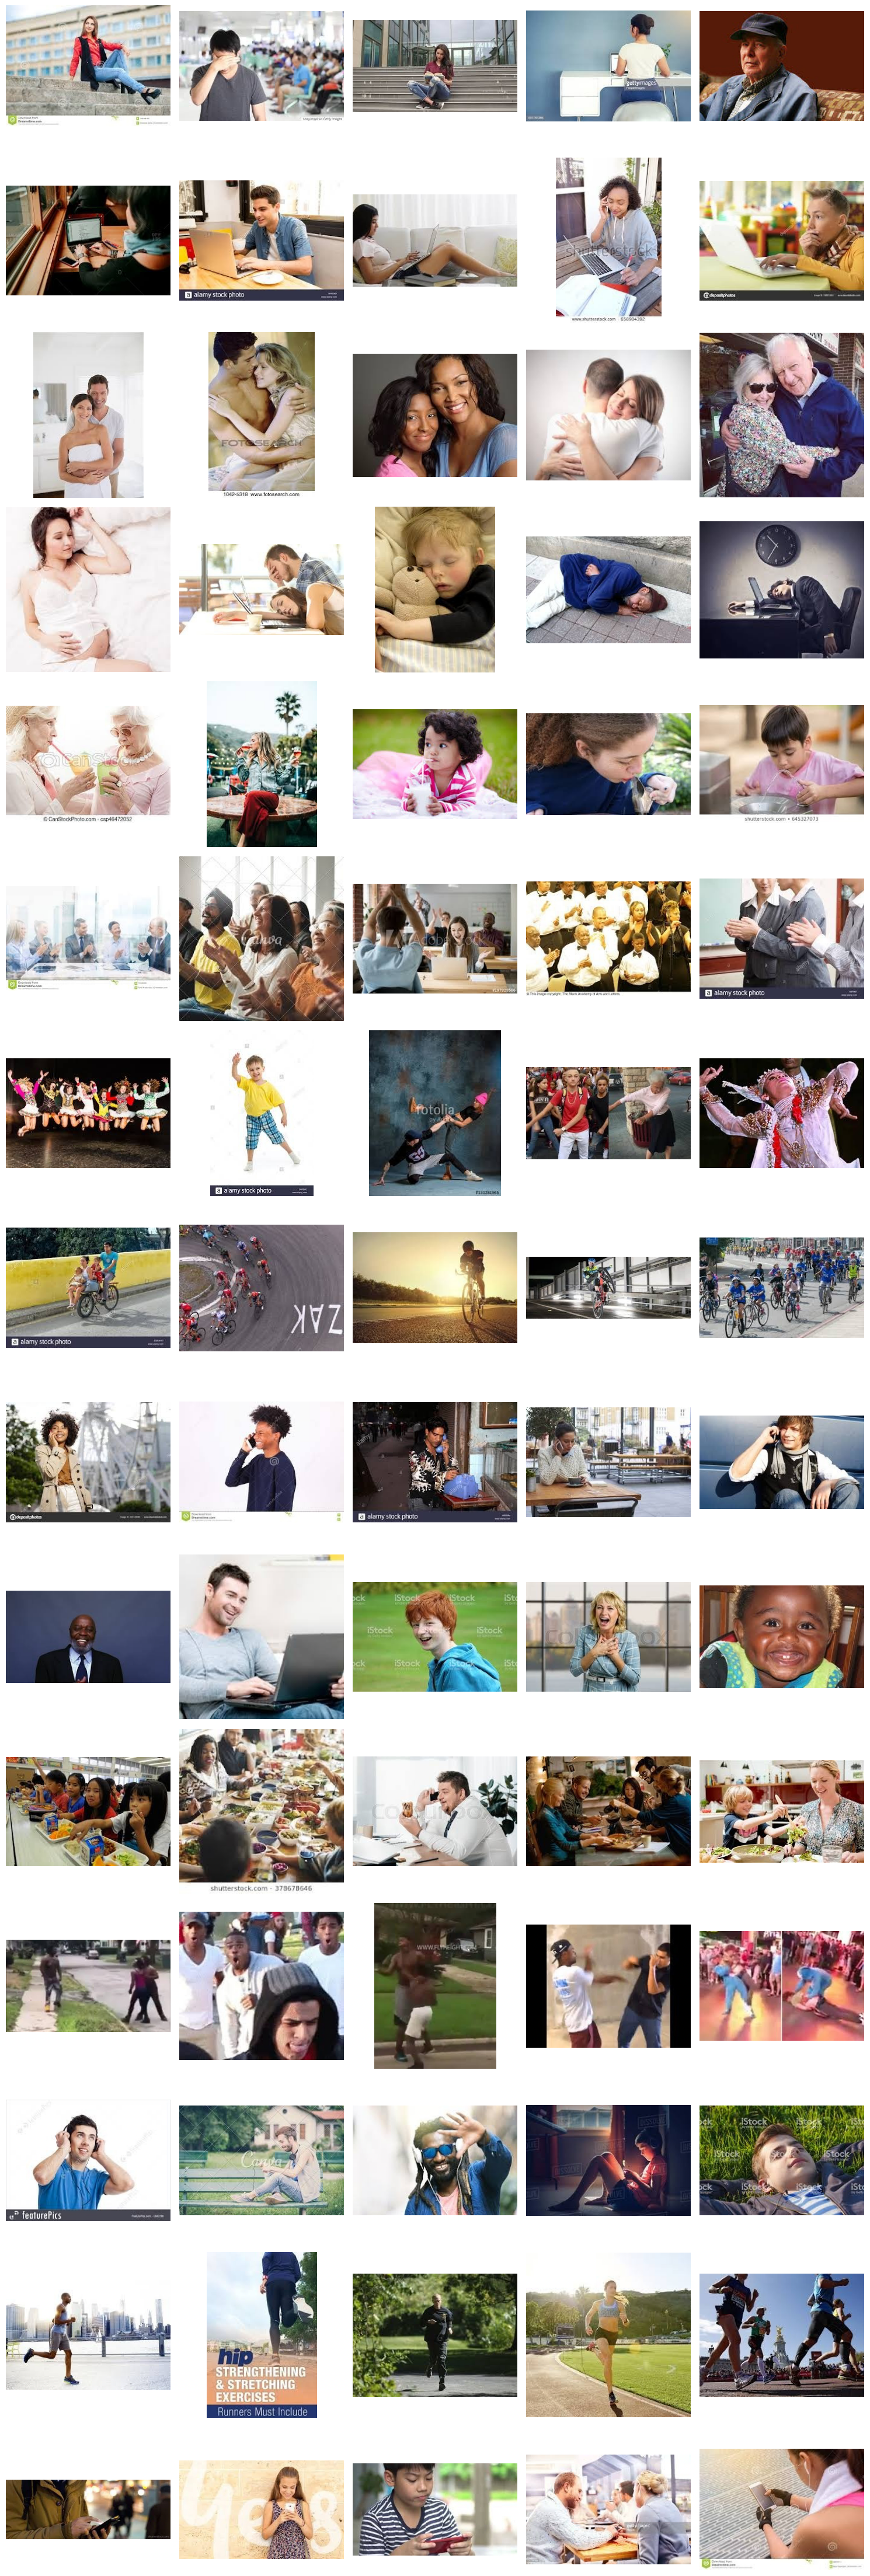

In [9]:
print("📷 Sample images from each class:")
show_samples(train_df, TRAIN_DIR, n=5)

# Encode labels for model compatibility

In [10]:
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])


In [11]:
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("🧾 Label Map:", label_map)

🧾 Label Map: {'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}


In [12]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),              
    transforms.ToTensor(),                      
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

In [13]:
label_map_clean = {str(k): int(v) for k, v in label_map.items()}

with open("label_map.json", "w") as f:
    json.dump(label_map_clean, f)

# Custom Dataset Class

In [14]:
class HARImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.cached_images = [to_tensor(Image.open(os.path.join(image_dir, fn)).resize((224, 224)).convert("RGB")) for fn in dataframe['filename']]
        self.transform = transforms.Compose([
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.cached_images[idx]  
        label = torch.tensor(self.df.loc[idx, 'label_encoded'], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


# Instantiate Dataset & Dataloaders

In [15]:
BATCH_SIZE = 16
NUM_WORKERS = 0

In [16]:
train_dataset = HARImageDataset(train_df, TRAIN_DIR, transform=image_transforms)
test_dataset = HARImageDataset(test_df, TEST_DIR, transform=image_transforms)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [18]:
print("✅ Step 2 complete: Custom dataset and dataloaders ready for training.")

✅ Step 2 complete: Custom dataset and dataloaders ready for training.


# Quick Sanity Check

In [19]:
def visualize_batch(data_loader, label_decoder):
    batch = next(iter(data_loader))
    images, labels = batch
    images = images[:6]
    labels = labels[:6]

    fig, axs = plt.subplots(1, 6, figsize=(15,3))
    for i in range(6):
        img = images[i].permute(1, 2, 0) * 0.5 + 0.5  
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(label_decoder[labels[i].item()])
    plt.show()

# Model Definition

In [20]:
class CNNLSTMModel(nn.Module):
    def __init__(self, num_classes=15, lstm_hidden_size=256, lstm_layers=1, dropout=0.5):
        super(CNNLSTMModel, self).__init__()

       
        base_model = models.resnet18(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(base_model.children())[:-2])  

        
        self.flatten_spatial = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(start_dim=2)  
        )

        
        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        
        self.classifier = nn.Sequential(
            nn.Linear(2 * lstm_hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):

        x = self.cnn_backbone(x)              
        x = self.flatten_spatial(x)           
        x = x.permute(0, 2, 1)                

        lstm_out, _ = self.lstm(x)            
        x = lstm_out[:, -1, :]                

        out = self.classifier(x)              
        return out

# Model Instantiation

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [22]:
model = CNNLSTMModel(num_classes=15)
model = model.to(device)

C:\Users\DSUCSCL9-35\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DSUCSCL9-35\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\DSUCSCL9-35\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


# Setup Loss and Optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Helper: Accuracy Metric

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

# Training & Validation Loop

In [25]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, running_acc = 0.0, 0.0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_acc += accuracy(outputs, labels) * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [26]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, running_acc = 0.0, 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_acc += accuracy(outputs, labels) * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)


In [27]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())


CUDA available: False
CUDA device count: 0


# Master Training Loop

In [28]:
NUM_EPOCHS = 10
best_val_acc = 0.0
save_path = 'best_cnn_lstm_model.pth'


In [29]:
def get_subset_loader(dataset, fraction=0.2):
    size = int(len(dataset) * fraction)
    indices = torch.randperm(len(dataset))[:size]
    subset = torch.utils.data.Subset(dataset, indices)
    return DataLoader(subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loader_subset = get_subset_loader(test_dataset, fraction=0.2)
    val_loss, val_acc = validate_one_epoch(model, val_loader_subset, criterion, device)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("Model saved!")


Epoch 1/10


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]


KeyError: 'label_encoded'

# Visualizing Training Curves

In [ ]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Advanced Metrics — Precision, Recall, F1, Confusion Matrix

In [ ]:
def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Inference on New Images

In [ ]:


def predict_image(model, image_path, device, class_names):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    
    return class_names[pred.item()]